In [1]:
import sys
from os import path
_up_one = path.abspath('../')
if _up_one not in sys.path:
    sys.path.insert(1, _up_one)

# Third-party
from astropy.io import ascii
import astropy.coordinates as coord
from astropy.table import hstack, Table, join
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.integrate import tplquad
from scipy.optimize import minimize
from tqdm import tqdm

import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
from lg_barycentric import LocalGroupBarycentric

In [2]:
mw_mass = 1.E12 * u.Msun
mw_rs = 15. * u.kpc

m31_mass = 2.E12 * u.Msun
m31_rs = 300*u.kpc / ((250*u.kpc)/mw_rs)
m31_rs

<Quantity 18. kpc>

In [3]:
lg_bary = LocalGroupBarycentric(mw_mass=mw_mass, m31_mass=m31_mass)

m31_cen = coord.SkyCoord(ra='00 42 44.330', dec='+41 16 07.50', distance=779*u.kpc,
                         unit=(u.hourangle, u.degree))
m31_cen = m31_cen.transform_to(lg_bary)

mw_cen = coord.Galactocentric(x=0*u.pc, y=0*u.pc, z=0*u.pc)
mw_cen = mw_cen.transform_to(lg_bary)

In [4]:
qs = dict()

qs[(1e12*u.Msun, 15*u.kpc)] = 0.386967
qs[(1e12*u.Msun, 20*u.kpc)] = 0.408714
qs[(1e12*u.Msun, 25*u.kpc)] = 0.426762

qs[(1.25e12*u.Msun, 15*u.kpc)] = 0.37111
qs[(1.25e12*u.Msun, 20*u.kpc)] = 0.39251
qs[(1.25e12*u.Msun, 25*u.kpc)] = 0.41032

qs[(1.5e12*u.Msun, 15*u.kpc)] = 0.36273
qs[(1.5e12*u.Msun, 20*u.kpc)] = 0.38396
qs[(1.5e12*u.Msun, 25*u.kpc)] = 0.40166

q = qs[(mw_mass, mw_rs)]
print(q)

0.386967


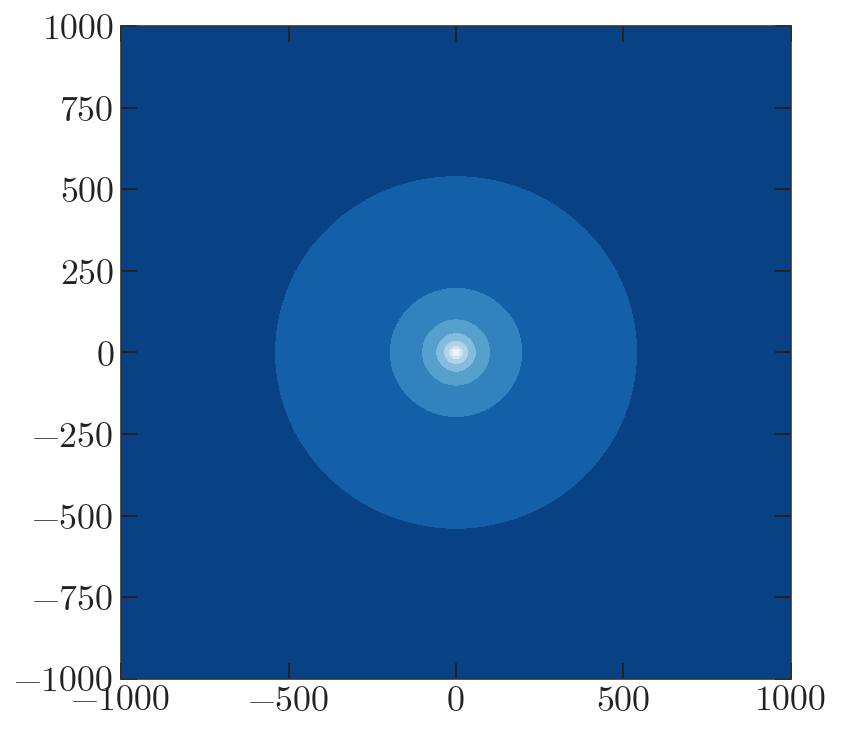

In [5]:
pot = gp.CCompositePotential()

# pot['mw'] = gp.NFWPotential(m=mw_mass, r_s=mw_rs, 
#                             units=galactic,
#                             origin=mw_cen.cartesian.xyz.to(u.kpc))

# pot['m31'] = gp.NFWPotential(m=m31_mass, r_s=m31_rs, 
#                              units=galactic,
#                              origin=m31_cen.cartesian.xyz)

pot['mw'] = gp.NFWPotential(m=mw_mass, r_s=mw_rs, 
                            units=galactic)

grid = np.linspace(-1000, 1000, 128)*u.kpc
_ = pot.plot_contours(grid=(grid, 0, grid), )

In [6]:
pot.mass_enclosed([250, 0, 0.])

<Quantity [1.9282834e+12] solMass>

In [7]:
H = gp.Hamiltonian(pot)

In [8]:
# nearby = ascii.read('../data/NearbyGalaxiese_formatted.txt')
# ra = (nearby['RA_h']+nearby['RA_m']/60.+nearby['RA_s']/3600) * u.hourangle
# dec = (nearby['Dec_d']+nearby['Dec_m']/60+nearby['Dec_s']/3600) * u.degree
# dist = coord.Distance(distmod=nearby['Dist'])

In [9]:
# colnames = ['dist', 
#             'pmra', 'pmra_error1', 'pmra_error2',
#             'pmdec', 'pmdec_error1', 'pmdec_error2',
#             'pmra_pmdec_corr', 
#             'rv', 'rv_error',
#             'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

# fritz18_gaia = ascii.read('../data/Fritz18_table2.txt', format='no_header', names=colnames)
# fritz18_more = ascii.read('../data/Table2_names.txt', format='csv')
# fritz18 = hstack((fritz18_more, fritz18_gaia))

# dist = coord.Distance(distmod=np.random.normal(fritz18_more['dm'], fritz18_more['dm_err'], size=(1024, len(fritz18_more)))).kpc
# fritz18_more['dist'] = np.mean(dist, axis=0)
# fritz18_more['dist_err'] = np.std(dist, axis=0)
# # fritz18_more['name', 'dist', 'dist_err'].pprint(max_width=1000, max_lines=10000)

---

In [10]:
galcen_frame = coord.Galactocentric(galcen_distance=8.1*u.kpc)

In [75]:
tbl = Table.read('../data/dwarf_kinematics_apw.csv')
tbl = tbl[~tbl['rv'].mask]

tbl2 = Table.read('../data/dwarf_ngas.csv')
tbl = join(tbl, tbl2, keys='name')

In [76]:
C_pm = np.zeros((len(tbl), 2, 2))
C_pm[:, 0, 0] = tbl['pmra_error1']**2 + tbl['pmra_error2']**2
C_pm[:, 1, 1] = tbl['pmdec_error1']**2 + tbl['pmdec_error2']**2
C_pm[:, 0, 1] = C_pm[:, 1, 0] = np.sqrt(C_pm[:, 0, 0]) * np.sqrt(C_pm[:, 1, 1]) * tbl['pmra_pmdec_corr']

In [77]:
mw2 = gp.MilkyWayPotential()

In [78]:
n_samples = 1024

In [60]:
all_peris = []
all_vperis = []

all_apos = []
all_vapos = []

for row, C in tqdm(zip(tbl, C_pm), total=len(tbl)):    
    ras = np.full(n_samples, row['ra'])
    decs = np.full(n_samples, row['dec'])
    dists = np.random.normal(row['dist'], row['dist_error'], 
                             size=n_samples) * u.kpc
    
    pmras, pmdecs = np.random.multivariate_normal([row['pmra'], row['pmdec']], C, 
                                                  size=n_samples).T * u.mas/u.yr
    rvs = np.random.normal(row['rv'], row['rv_error'], size=n_samples) * u.km/u.s
    
    c_samples = coord.SkyCoord(ra=ras*u.deg,
                               dec=decs*u.deg,
                               distance=dists,
                               pm_ra_cosdec=pmras, 
                               pm_dec=pmdecs,
                               radial_velocity=rvs)
    
    w0 = gd.PhaseSpacePosition(c_samples.transform_to(galcen_frame).data)
    orbits = mw2.integrate_orbit(w0, dt=-1, t1=0, t2=-4*u.Gyr)
    # orbits = pot.integrate_orbit(w0, dt=-1, t1=0, t2=-4*u.Gyr)
    
    r_gc = orbits.physicsspherical.r
    v_gc = np.sqrt(np.sum(orbits.v_xyz**2, axis=0))
    
    peri_idx = r_gc.argmin(axis=0)
    peris = u.Quantity([r_gc[i, j] for j, i in enumerate(peri_idx)])
    v_peris = u.Quantity([v_gc[i, j] for j, i in enumerate(peri_idx)]).to(u.km/u.s)
    
    apo_idx = r_gc.argmax(axis=0)
    apos = u.Quantity([r_gc[i, j] for j, i in enumerate(apo_idx)])
    v_apos = u.Quantity([v_gc[i, j] for j, i in enumerate(apo_idx)]).to(u.km/u.s)
    
    all_peris.append(peris)
    all_vperis.append(v_peris)
    
    all_apos.append(apos)
    all_vapos.append(v_apos)

all_peris = u.Quantity(all_peris)
all_vperis = u.Quantity(all_vperis)

all_apos = u.Quantity(all_apos)
all_vapos = u.Quantity(all_vapos)

100%|██████████| 39/39 [02:32<00:00,  3.91s/it]


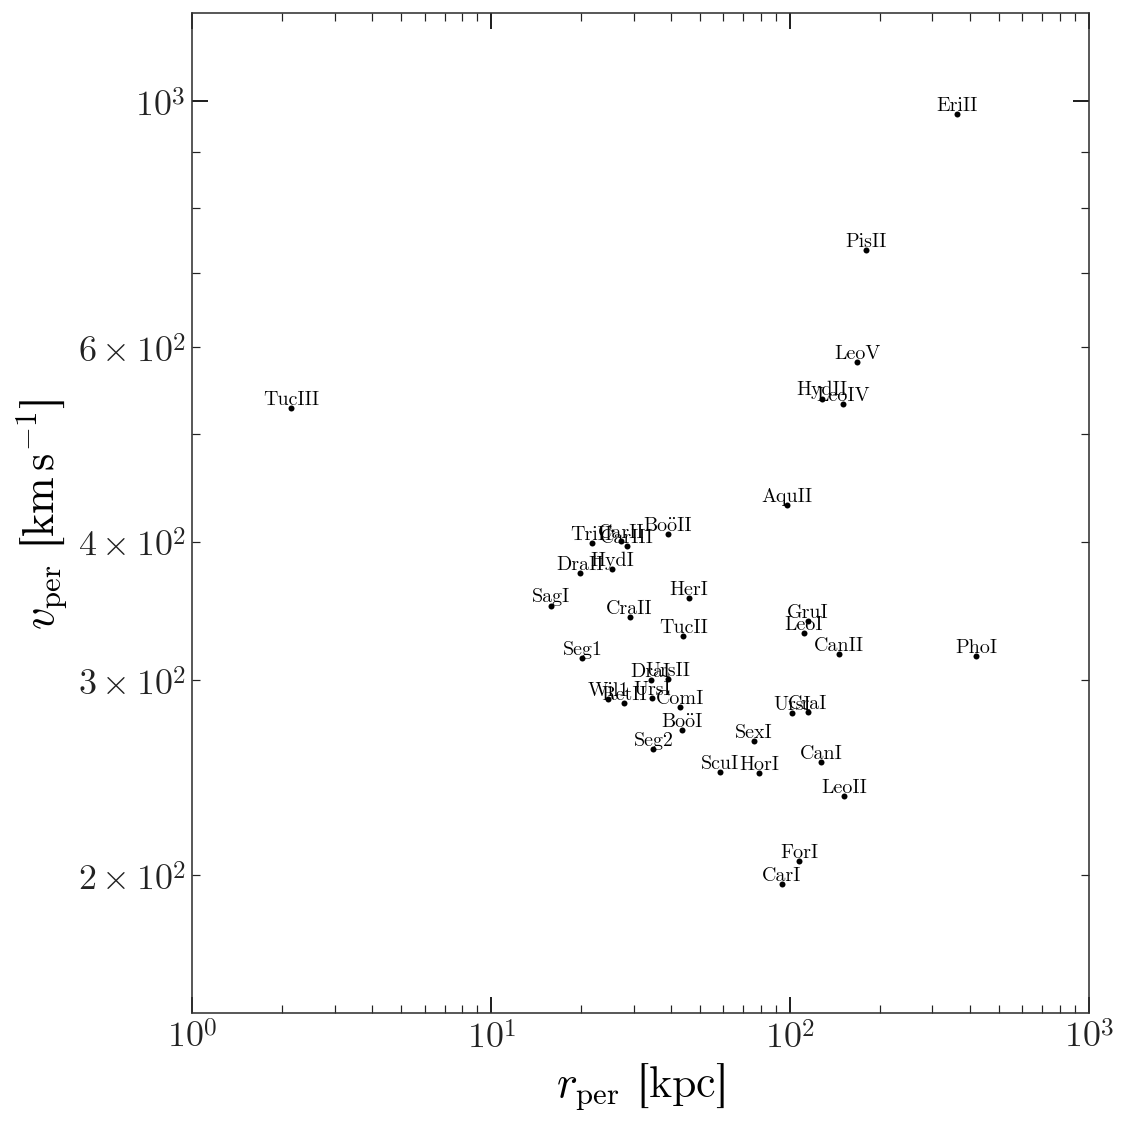

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.loglog(np.mean(all_peris, axis=1), np.mean(all_vperis, axis=1), 
          ls='none', marker='o', ms=3., color='k');

for row, rr, vv in zip(tbl, np.mean(all_peris, axis=1), np.mean(all_vperis, axis=1)):
    a, *_, b = row['name'].split(" ")
    new_name = a[:3]+b
    ax.text(rr.value, vv.value, new_name, 
            ha='center', va='bottom')

ax.set_xlabel(r'$r_{\rm per}$ ' + '[kpc]')
ax.set_ylabel(r'$v_{\rm per}$ ' + '[{:latex_inline}]'.format(u.km/u.s))

ax.set_xlim(1, 1e3)
ax.set_ylim(150, 1.2e3)

fig.set_facecolor('w')
fig.tight_layout()

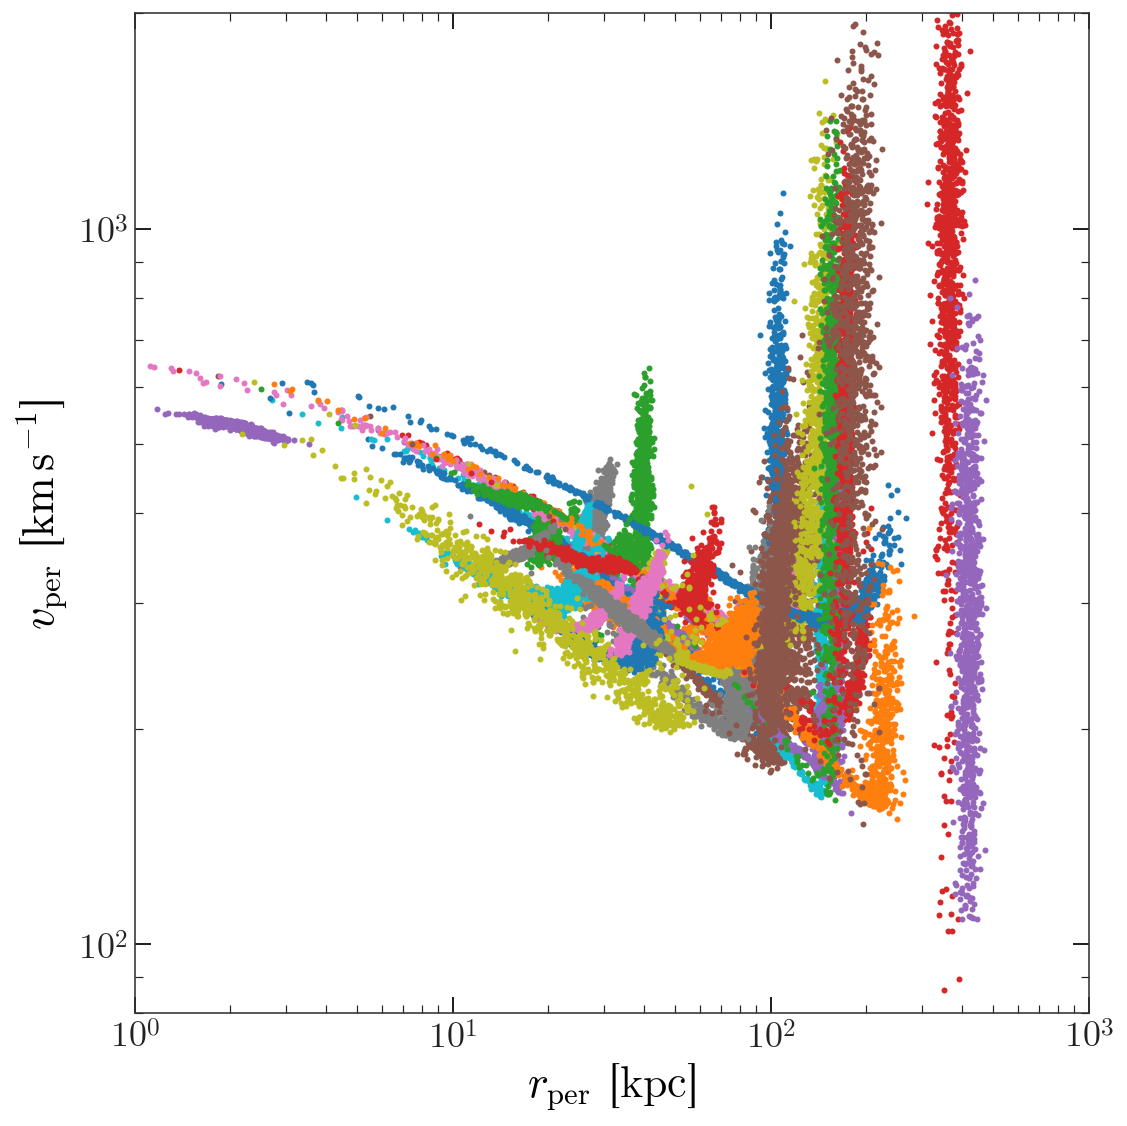

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.loglog(all_peris.T, all_vperis.T, ls='none', marker='o', ms=3.);
ax.set_xlabel(r'$r_{\rm per}$ ' + '[kpc]')
ax.set_ylabel(r'$v_{\rm per}$ ' + '[{:latex_inline}]'.format(u.km/u.s))
ax.set_xlim(1, 1e3)
ax.set_ylim(80, 2e3)
fig.set_facecolor('w')
fig.tight_layout()

In [80]:
# vel. disp. values
# s = tbl['vdisp'] * u.km/u.s
s = np.random.normal(tbl['vdisp'], 0.2*tbl['vdisp'], size=all_vperis.T.shape).T * u.km/u.s

# n_gas = tbl['ngas'] / u.cm**3
# vsat_p = np.mean(all_vperis, axis=1)
# vsat_a = np.mean(all_vapos, axis=1)
n_gas = tbl['ngas'][:, None] / u.cm**3
vsat_p = all_vperis
vsat_a = all_vapos

n_halo_p = s**2 * n_gas / (vsat_p**2)
n_halo_a = s**2 * n_gas / (vsat_a**2)

n_halo_p_err = np.std(n_halo_p, axis=1)
n_halo_a_err = np.std(n_halo_a, axis=1)
n_halo_p = np.mean(n_halo_p, axis=1)
n_halo_a = np.mean(n_halo_a, axis=1)

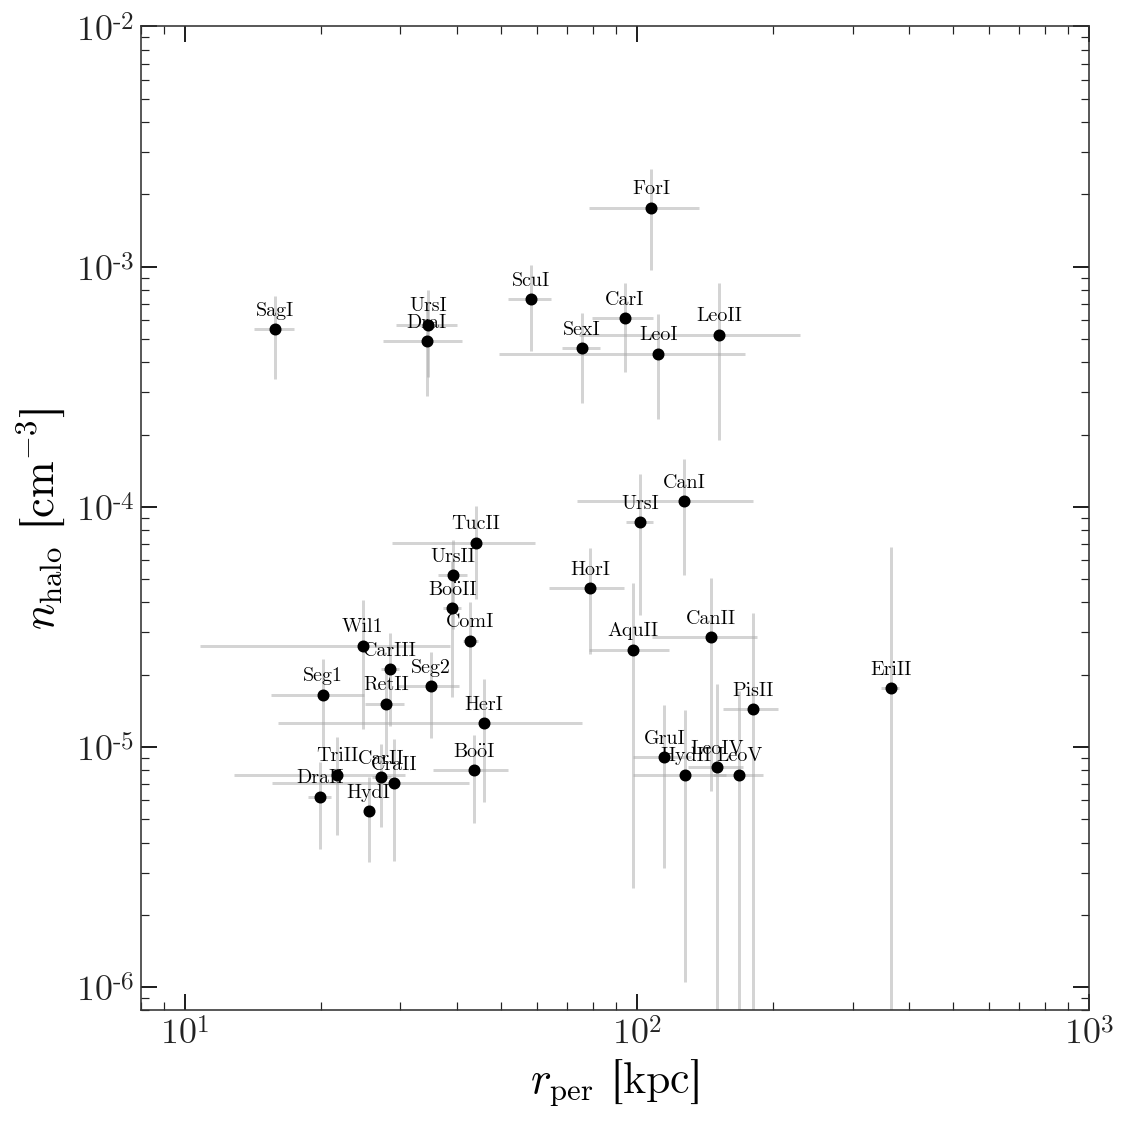

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter(np.mean(all_peris, axis=1), n_halo_p.value, c='k')
ax.errorbar(np.mean(all_peris, axis=1).value, n_halo_p.value, 
            xerr=np.std(all_peris, axis=1).value,
            yerr=n_halo_p_err.value,
            marker='o', ls='none', c='#aaaaaa', zorder=-100, alpha=0.5)

for row, rr, yy in zip(tbl, np.mean(all_peris, axis=1), n_halo_p):
    if yy.value == 0 or yy.value < 1e-6:
        continue
        
    a, *_, b = row['name'].split(" ")
    new_name = a[:3] + b
    ax.text(rr.value, yy.value+0.1*yy.value, new_name, 
            ha='center', va='bottom')

ax.set_xlabel(r'$r_{\rm per}$ ' + '[kpc]')
ax.set_ylabel(r'$n_{\rm halo}$' + ' [{:latex_inline}]'.format(u.cm**-3))

ax.set_xlim(8, 1e3)
ax.set_ylim(8e-7, 1e-2)
ax.set_yscale('log')
ax.set_xscale('log')

fig.set_facecolor('w')
fig.tight_layout()

fig.savefig('../plots/rper_nhalo.pdf')

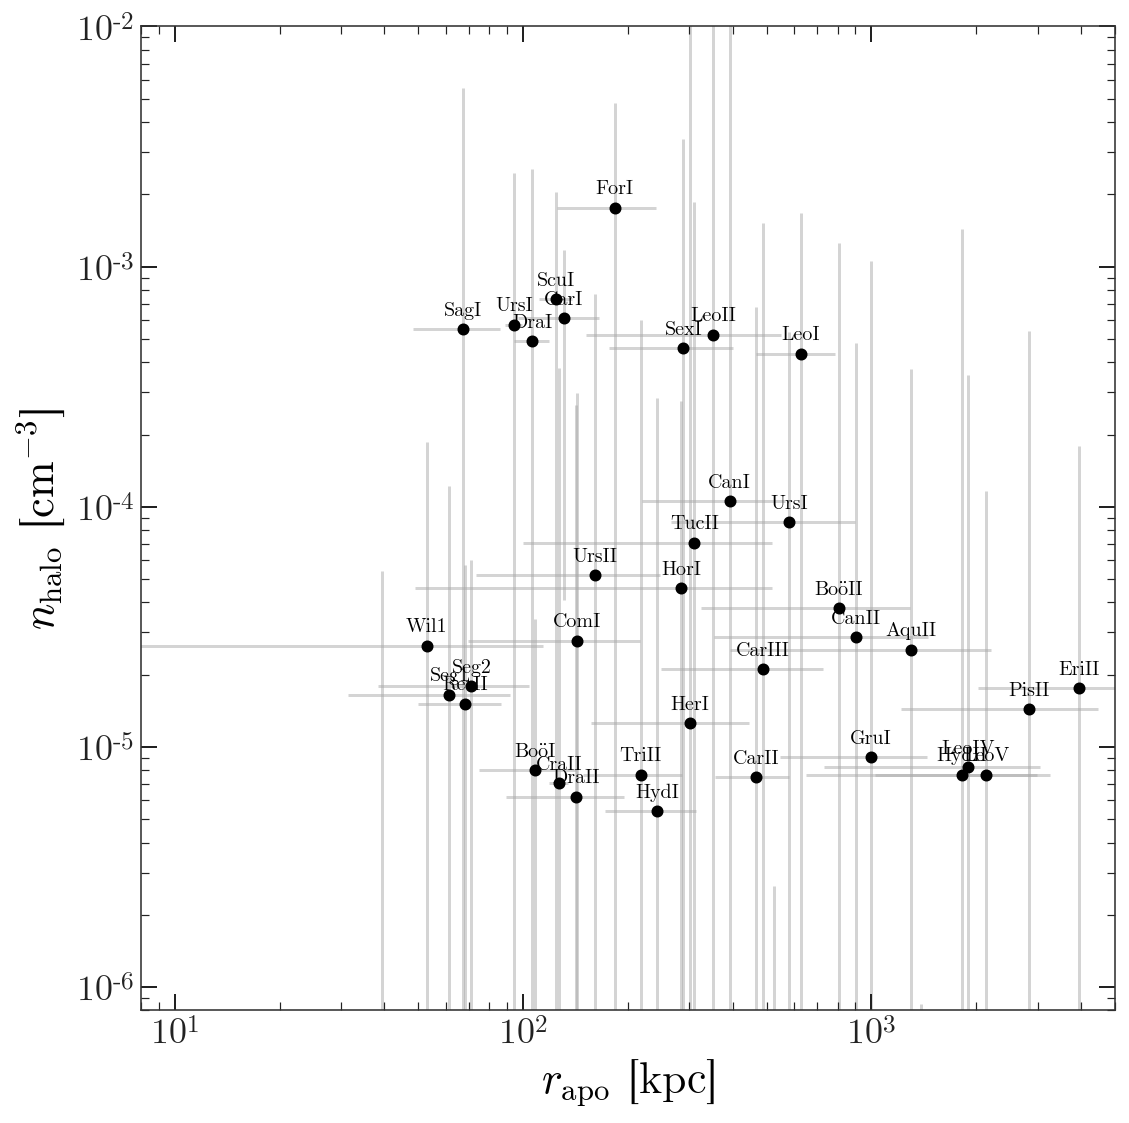

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter(np.mean(all_apos, axis=1), n_halo_p.value, c='k')
ax.errorbar(np.mean(all_apos, axis=1).value, n_halo_p.value, 
            xerr=np.std(all_apos, axis=1).value,
            yerr=n_halo_a_err.value,
            marker='o', ls='none', c='#aaaaaa', zorder=-100, alpha=0.5)

for row, rr, yy in zip(tbl, np.mean(all_apos, axis=1), n_halo_p):
    if yy.value == 0 or yy.value < 1e-6:
        continue
        
    a, *_, b = row['name'].split(" ")
    new_name = a[:3] + b
    ax.text(rr.value, yy.value+0.1*yy.value, new_name, 
            ha='center', va='bottom')

ax.set_xlabel(r'$r_{\rm apo}$ ' + '[kpc]')
ax.set_ylabel(r'$n_{\rm halo}$' + ' [{:latex_inline}]'.format(u.cm**-3))

ax.set_xlim(8, 5e3)
ax.set_ylim(8e-7, 1e-2)
ax.set_yscale('log')
ax.set_xscale('log')

fig.set_facecolor('w')
fig.tight_layout()

fig.savefig('../plots/rapo_nhalo.pdf')

In [84]:
mw2.mass_enclosed([250., 0, 0])

<Quantity [1.09650474e+12] solMass>

In [64]:
m31_c = coord.SkyCoord(10.68470833, 41.268, unit=u.deg)

In [69]:
all_orbits_c = []
all_orbits_names = []
frac_m31 = []
for row, C, apo in tqdm(zip(tbl, C_pm, np.mean(all_apos, axis=1)), total=len(tbl)):   
    if apo < 300*u.kpc:
        continue
    
    ras = np.full(n_samples, row['ra'])
    decs = np.full(n_samples, row['dec'])
    dists = np.random.normal(row['dist'], row['dist_error'], 
                             size=n_samples) * u.kpc
    
    pmras, pmdecs = np.random.multivariate_normal([row['pmra'], row['pmdec']], C, 
                                                  size=n_samples).T * u.mas/u.yr
    rvs = np.random.normal(row['rv'], row['rv_error'], size=n_samples) * u.km/u.s
    
    c_samples = coord.SkyCoord(ra=ras*u.deg,
                               dec=decs*u.deg,
                               distance=dists,
                               pm_ra_cosdec=pmras, 
                               pm_dec=pmdecs,
                               radial_velocity=rvs)
    
    w0 = gd.PhaseSpacePosition(c_samples.transform_to(galcen_frame).data)
    orbits = mw2.integrate_orbit(w0, dt=-1, t1=0, t2=-2*u.Gyr)
    # orbits = pot.integrate_orbit(w0, dt=-1, t1=0, t2=-4*u.Gyr)
    
    orbits_c = orbits.to_coord_frame(coord.ICRS, galactocentric_frame=galcen_frame)
    all_orbits_c.append(orbits_c)
    all_orbits_names.append(row['name'])
    
    mask = (orbits_c.separation(m31_c) < 20*u.deg).any(axis=0)
    frac_m31.append(mask.sum() / n_samples)

100%|██████████| 39/39 [00:41<00:00,  1.07s/it]


In [74]:
for name, f in zip(all_orbits_names, frac_m31):
    print(name, f)

Aquarius II 0.03125
Boötes II 0.0
Canes Venatici I 0.005859375
Canes Venatici II 0.0
Carina II 0.9814453125
Carina III 0.0
Crater I 0.095703125
Eridanus II 0.001953125
Grus I 0.0
Hercules I 0.2685546875
Hydra II 0.10546875
Leo I 0.0546875
Leo II 0.01953125
Leo IV 0.013671875
Leo V 0.0126953125
Phoenix I 0.0009765625
Pisces II 0.3447265625
Tucana II 0.0
Ursa Major I 0.0


In [57]:
for orbits_c, name in zip(all_orbits_c, all_orbits_names):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.plot(orbits_c.ra, orbits_c.dec, 
            marker='.', ls='none')
    ax.scatter(m31_c.ra, m31_c.dec, marker='o', s=150, color='#aaaaaa', zorder=10)
    ax.set_xlim(360, 0)
    ax.set_ylim(-90, 90)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    fig.savefig('../plots/sky_orbits_{}.png'.format(name), dpi=250)
    plt.close(fig)

---

In [149]:
names = ['peri', 'peri_err1', 'peri_err2', 'apo', 'apo_err1', 'apo_err2'] + ['x'+str(i) for i in range(12)]
fritz_orbits = ascii.read('../data/Fritz18_table3.txt', names=names)

In [150]:
c = coord.SkyCoord(ra=fritz18['ra']*u.deg,
                   dec=fritz18['dec']*u.deg,
                   distance=fritz18['dist']*u.kpc,
                   pm_ra_cosdec=fritz18['pmra']*u.mas/u.yr,
                   pm_dec=fritz18['pmdec']*u.mas/u.yr,
                   radial_velocity=fritz18['rv']*u.km/u.s)
galcen = c.transform_to(galcen_frame)

In [151]:
w0 = gd.PhaseSpacePosition(galcen.data)

In [152]:
orbits = H.integrate_orbit(w0, dt=-5*u.Myr, n_steps=2000)

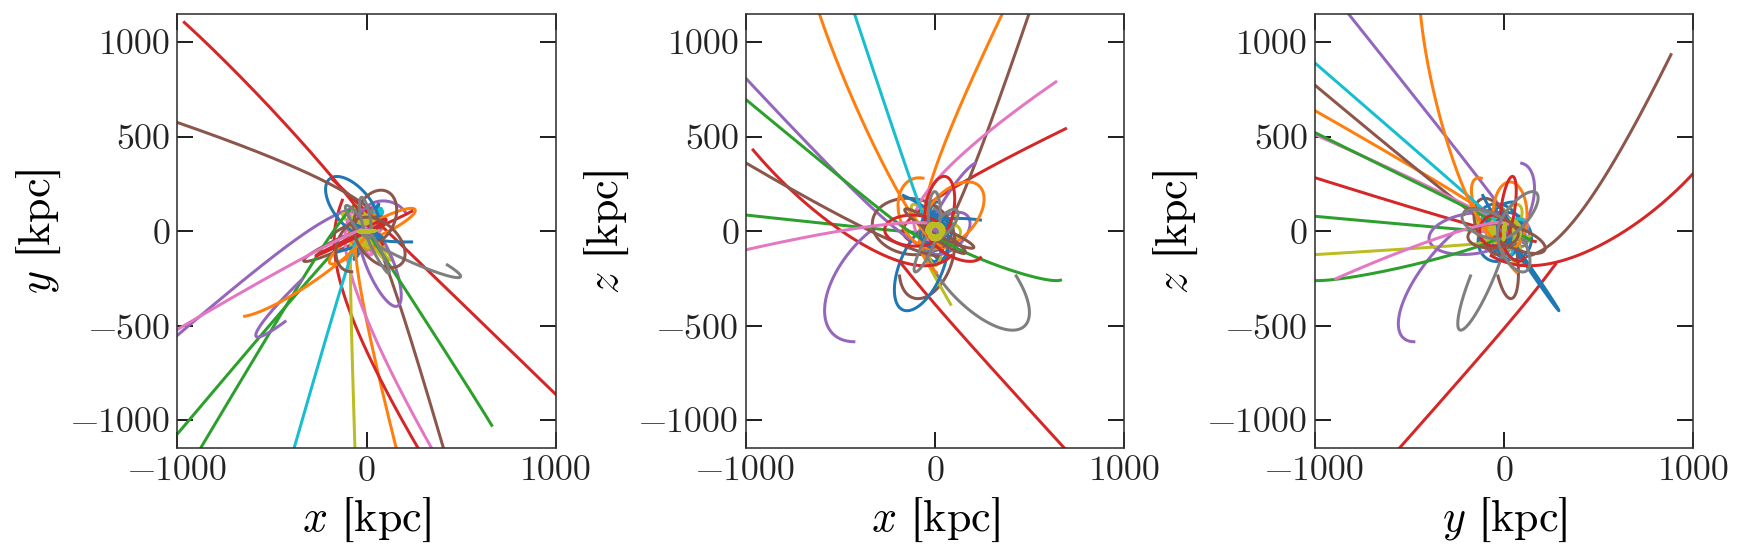

In [153]:
fig = orbits.plot()
for ax in fig.axes:
    ax.set_xlim(-1000, 1000)
    ax.set_ylim(-1000, 1000)

In [154]:
for i, name in enumerate(fritz18['name']):
    print('{} {:.0f} {:.0f} fritz: {:.0f} {:.0f}'
          .format(name, 
                  orbits[:, i].pericenter(), orbits[:, i].apocenter(),
                  fritz_orbits['peri'][i], fritz_orbits['apo'][i]))

Aquarius II 100 kpc 174 kpc fritz: 95 190
Boötes I 57 kpc nan kpc fritz: 32 77
Boötes II nan kpc nan kpc fritz: 38 167
Canes Venatici I 169 kpc nan kpc fritz: 54 254
Canes Venatici II 164 kpc nan kpc fritz: 85 234
Carina I 31 kpc nan kpc fritz: 60 106
Carina II 28 kpc 130 kpc fritz: 26 118
Carina III 30 kpc 138 kpc fritz: 28 106
Coma Berenices I 31 kpc 202 kpc fritz: 42 63
Crater I 26 kpc 145 kpc fritz: 46 153
Crater II 18 kpc 117 kpc fritz: 18 124
Draco I 27 kpc 98 kpc fritz: 28 91
Draco II 22 kpc 80 kpc fritz: 19 62
Eridanus II 349 kpc nan kpc fritz: 356 70846
Fornax I 75 kpc 429 kpc fritz: 58 147
Grus I 95 kpc 372 kpc fritz: 58 329
Hercules I 111 kpc nan kpc fritz: 14 187
Horologium I 77 kpc 731 kpc fritz: 70 94
Hydra II 93 kpc nan kpc fritz: 116 676
Hydrus I 24 kpc 60 kpc fritz: 25 73
Leo I 56 kpc 535 kpc fritz: 45 590
Leo II 96 kpc 342 kpc fritz: 41 238
Leo IV 141 kpc nan kpc fritz: 150 1794
Leo V 164 kpc nan kpc fritz: 165 4079
Phoenix I nan kpc 946 kpc fritz: 263 1549
Pisces II 